In [ ]:
#| default_exp hooks

In [1]:
#| export
import random, math, torch, numpy as np, matplotlib.pyplot as plt
from tinyai.learner import *
from tinyai.model import *
import fastcore.all as fc
from functools import partial

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
# |export
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [4]:
import tiktoken
import os

enc = tiktoken.get_encoding("gpt2")

def get_tokens(file_path):
    with open(input_file) as f:
        text = f.read()
    tokens = enc.encode(text)
    return tokens

cwd = os.getcwd()
input_file = f"{cwd}/fast-nanogpt/input.txt"
tokens = get_tokens(input_file)[:10000]
train, valid = tokens[:int(len(tokens)*0.8)], tokens[int(len(tokens)*0.8):]

In [5]:
# | export
class DataSet:
    def __init__(self, tokens, T=32):
        self.tokens = tokens
        self.T = T

    def __len__(self):
        return (len(self.tokens) - 1) // self.T

    def __getitem__(self, i):
        x = self.tokens[i * self.T : (i + 1) * self.T]
        y = self.tokens[i * self.T + 1 : (i + 1) * self.T + 1]
        return x, y

In [6]:
tds = DataSet(torch.tensor(train))
dls = dls = DataLoaders.from_dd([tds, None], batch_size=4)

In [7]:
x, y = next(iter(dls.train))
x[0], y[0]

(tensor([ 5962, 22307,    25,   198,  8421,   356,  5120,   597,  2252,    11,
          3285,   502,  2740,    13,   198,   198,  3237,    25,   198,  5248,
           461,    11,  2740,    13,   198,   198,  5962, 22307,    25,   198,
          1639,   389]),
 tensor([22307,    25,   198,  8421,   356,  5120,   597,  2252,    11,  3285,
           502,  2740,    13,   198,   198,  3237,    25,   198,  5248,   461,
            11,  2740,    13,   198,   198,  5962, 22307,    25,   198,  1639,
           389,   477]))

In [8]:
model = get_model()
cbs = [TrainCB(), DeviceCB(), MetricsCB(), ProgressCB()]
lrn = Learner(model, dls=dls, opt_func=optim.AdamW, cbs=cbs, lr=3e-4)
lrn.fit(1, valid=False)

loss,epoch,train
7.474,0,train


## How to evaluate the training process
We can evaluate the training process by evaluating the activations. The activations of each layer should roughly have mean of 0 and standard deviation of 1.


In [9]:
# | export
class Hook:
    def __init__(self, m, f):
        self.hook = m.register_forward_hook(partial(f, self))
        # print(self.hook, m)

    def remove(self):
        self.hook.remove()

    def __del__(self):
        self.remove()

In [10]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, "stats"):
        hook.stats = ([], [])  # mean, std of activations
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [11]:
#| export
class Hooks(list):
    def __init__(self, ms, f):
        super().__init__([Hook(m, f) for m in ms])

    def __enter__(self, *args):
        return self

    def __exit__(self, *args):
        self.remove()

    def __del__(self):
        self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)

    def remove(self):
        for h in self:
            h.remove()

In [12]:
# | export
class HooksCallback(Callback):
    def __init__(
        self, hookfunc, mod_filter=fc.noop, on_train=True, on_valid=False, mods=None
    ):
        fc.store_attr()
        super().__init__()

    def before_fit(self, learn):
        if self.mods:
            mods = self.mods
        else:
            mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))

    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training):
            self.hookfunc(*args, **kwargs)

    def after_fit(self, learn):
        self.hooks.remove()

    def __iter__(self):
        return iter(self.hooks)

    def __len__(self):
        return len(self.hooks)

In [ ]:
# | export
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, "stats"):
        hook.stats = ([], [], [])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40, 0, 10))

In [16]:
def fit(model, epochs=1, xtra_cbs=None):
    lrn = Learner(model, dls=dls, opt_func=optim.AdamW, cbs=cbs + fc.L(xtra_cbs), lr=3e-4)
    lrn.fit(epochs, valid=False)
    return lrn

In [14]:
model = get_model()

In [17]:
set_seed(1)
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(Block))
lrn = fit(model, xtra_cbs=[hc])

<torch.utils.hooks.RemovableHandle object at 0x7f4f160f73d0> Block(
  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): CausalSelfAttention(
    (c_attn): Linear(in_features=768, out_features=2304, bias=True)
    (c_proj): Linear(in_features=768, out_features=768, bias=True)
  )
  (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): MLP(
    (c_fc): Linear(in_features=768, out_features=3072, bias=True)
    (gelu): GELU(approximate='tanh')
    (c_proj): Linear(in_features=3072, out_features=768, bias=True)
  )
)
<torch.utils.hooks.RemovableHandle object at 0x7f4f102c2bd0> Block(
  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): CausalSelfAttention(
    (c_attn): Linear(in_features=768, out_features=2304, bias=True)
    (c_proj): Linear(in_features=768, out_features=768, bias=True)
  )
  (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): MLP(
    (c_fc): Linear(in_features=768, out_features=3072, bias=Tru

loss,epoch,train
6.376,0,train


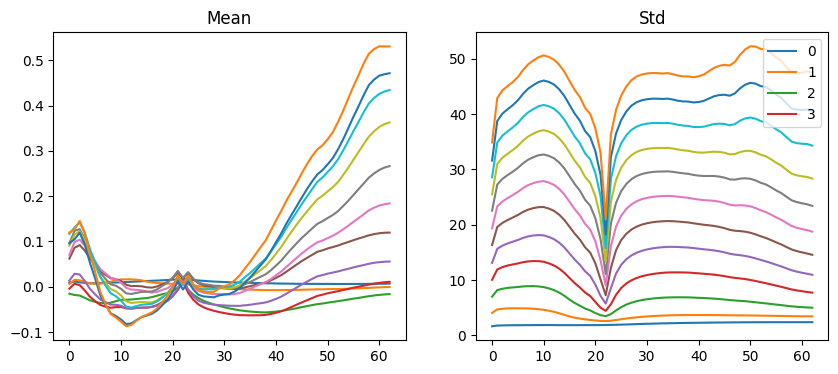

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for h in hc:
    for i in 0, 1:
        axs[i].plot(h.stats[i])
axs[0].set_title("Mean")
axs[1].set_title("Std")
plt.legend(range(4))